<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/7_multi_model_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check for causality

😈 **Task 3:** Run a Granger test between `temp` and `o3`. Is there any directional causality?

😈 **Question 3:** Why is Granger causality not the same as actual causality?


In [1]:
'''
from statsmodels.tsa.stattools import grangercausalitytests
for col in ["no2", "temp", "no", "press"]:
    print(f"\nTesting if {col} Granger-causes o3:")
    grangercausalitytests(dataframe[['o3', col]], maxlag=4)
'''

'\nfrom statsmodels.tsa.stattools import grangercausalitytests\nfor col in ["no2", "temp", "no", "press"]:\n    print(f"\nTesting if {col} Granger-causes o3:")\n    grangercausalitytests(dataframe[[\'o3\', col]], maxlag=4)\n'

# Homework Task 1

Imports:

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU

from transformers import (
    EarlyStoppingCallback,
    PatchTSTConfig,
    PatchTSTForPrediction,
    Trainer,
    TrainingArguments,
)

import torch

import pandas as pd
import numpy as np
import pickle

from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError

from sklearn.metrics import mean_squared_error

from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore", module="torch")

/home/philipp/Documents/mless/venv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-21 13:39:38.483356: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 13:39:38.489566: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-21 13:39:38.534432: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-21 13:39:38.577032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to

Cross-model variables:

In [3]:
# Checkpoints
checkpoint_dir = "./checkpoint"

# Training / Prediction
context_length = 336 # In hours
forecast_horizon = 96 # In hours
patch_length = 16 # (PatchTST)
num_workers = 16  # Reduce this if you have low number of CPU cores
batch_size = 64  # Adjust according to GPU memory

# Metadata
desired_station = 'DEBW073' # or: 'DENW094'
observable_columns = ["temp"] #["no2", "temp", "o3", "no", "press"]
target_columns = observable_columns #["o3"]
id_columns = ['station_code','latitude','longitude']
num_variables = len(observable_columns)

# Data (not normalized)
'''
data = pd.read_csv("data.csv", parse_dates=["datetime"])
data = data[data['station_code'] == desired_station]
data['latitude'] = data['latitude'].astype(int)
data['longitude'] = data['longitude'].astype(int)
'''

# Data (normalized)
data_normalized = pd.read_csv("data_normalized.csv",parse_dates=["datetime"])
data_normalized = data_normalized[data_normalized['station_code'] == desired_station]
data_normalized['latitude'] = data_normalized['latitude'].astype(int)
data_normalized['longitude'] = data_normalized['longitude'].astype(int)

data = data_normalized
print(data.head())

# Stats helper - use multi-station data for consistent normalization
data_all_stations = data_normalized[data_normalized['station_code'].isin(['DEBW073', 'DEHE020', 'DENW094'])]
scaler_stats = {col: {'mean': data_all_stations[col].mean(), 'std': data_all_stations[col].std()} for col in observable_columns}
print(f"Scaler stats (multi-station): {scaler_stats}")

# Data (normalized + sequenced)
# ! Note: the sequenced data in the below .pkl binaries has a context_length = 336 and forecast_horizon = 96 "hard-coded"
with open("./X_train_corrected.pkl", "rb") as f:
    X_train_full = pickle.load(f)

with open("./X_test_corrected.pkl", "rb") as f:
    X_test_full = pickle.load(f)

with open("./y_train_corrected.pkl", "rb") as f:
    y_train_full = pickle.load(f)

with open("./y_test_corrected.pkl", "rb") as f:
    y_test_full = pickle.load(f)

print(f"X_train_full shape: {X_train_full.shape}, y_train_full shape: {y_train_full.shape}")
print(f"X_test_full shape: {X_test_full.shape}, y_test_full shape: {y_test_full.shape}")

X_train = X_train_full[:,:,len(observable_columns)].copy()
X_test = X_test_full[:,:,len(observable_columns)].copy()
y_train = y_train_full[:,:,len(observable_columns)].copy()
y_test = y_test_full[:,:,len(observable_columns)].copy()

# Flatten input features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(observable_columns))
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], len(observable_columns))
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1],  len(observable_columns))
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],  len(observable_columns))

X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test,  dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test  = np.array(y_test,  dtype=np.float32)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

   longitude  latitude station_code                  datetime      temp
0          7        47      DEBW073 1997-01-01 00:00:00+00:00 -2.564191
1          7        47      DEBW073 1997-01-01 01:00:00+00:00 -2.686422
2          7        47      DEBW073 1997-01-01 02:00:00+00:00 -2.686422
3          7        47      DEBW073 1997-01-01 03:00:00+00:00 -2.808654
4          7        47      DEBW073 1997-01-01 04:00:00+00:00 -2.808654
X_train_full shape: (427357, 336, 2), y_train_full shape: (427357, 96, 2)
X_test_full shape: (106841, 336, 2), y_test_full shape: (106841, 96, 2)
X_train shape: (427357, 336, 1), y_train shape: (427357, 96, 1)
X_test shape: (106841, 336, 1), y_test shape: (106841, 96, 1)


## PatchTST

Prerequisites:
1) patchtst checkpoint

In [4]:
'''
# Data Preparation: Manual Train/Test/Validation Dataset Split
num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_valid = len(data) - num_train - num_test
border1s = [
    0,
    num_train - context_length,
    len(data) - num_test - context_length,
]
border2s = [num_train, num_train + num_valid, len(data)]

train_start_index = border1s[0]  # None indicates beginning of dataset
train_end_index = border2s[0]

valid_start_index = border1s[1]
valid_end_index = border2s[1]

test_start_index = border1s[2]
test_end_index = border2s[2]

'''

# Model Configuration
tst_checkpoint_dir = checkpoint_dir + "/patchtst/TOAR/model/pretrain/"
tst_pretrainOutput_dir = checkpoint_dir + "/patchtst/TOAR/pretrain/output/"
tst_pretrainLogs_dir = checkpoint_dir + "/patchtst/TOAR/pretrain/logs/"

'''

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)

valid_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)

test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column="datetime",
    id_columns=id_columns,
    input_columns=observable_columns,
    output_columns=target_columns,
    scaling=False, # Otherwise, this makes PatchTST not comparable to the other models..
)
time_series_preprocessor = time_series_preprocessor.train(train_data)

train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column="datetime",
    observable_columns=observable_columns,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

valid_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(valid_data),
    id_columns=id_columns,
    timestamp_column="datetime",
    observable_columns=observable_columns,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

test_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(test_data),
    id_columns=id_columns,
    timestamp_column="datetime",
    observable_columns=observable_columns,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
'''

## New data handling:
print("=== Inspecting pkl file structure ===")
print(f"X_train_full shape: {X_train_full.shape}")
print(f"First few station codes in training data: {X_train_full[:5, 0, 0]}")
print(f"Unique station codes: {np.unique(X_train_full[:, 0, 0])}")

# Find indices for desired station
train_station_mask = X_train_full[:, 0, 0] == desired_station
test_station_mask = X_test_full[:, 0, 0] == desired_station

print(f"Found {train_station_mask.sum()} training samples for desired station {desired_station}")
print(f"Found {test_station_mask.sum()} test samples for desired stations {desired_station}")

if train_station_mask.sum() == 0:
    print(f"WARNING: No samples for desired station {desired_station} found. Available stations:")
    print(np.unique(X_train_full[:, 0, 0]))
    # Use first available station as fallback
    first_station = np.unique(X_train_full[:, 0, 0])[0]
    print(f"Using {first_station} as fallback station")
    train_station_mask = X_train_full[:, 0, 0] == first_station
    test_station_mask = X_test_full[:, 0, 0] == first_station

# Extract temp variable (column 1 = variable values, column 0 = station codes)
temp_var_idx = 1

# Get the sequences for our station and variable
X_train_temp = X_train_full[train_station_mask, :, temp_var_idx].astype(np.float32)
y_train_temp = y_train_full[train_station_mask, :, temp_var_idx].astype(np.float32)
X_test_temp = X_test_full[test_station_mask, :, temp_var_idx].astype(np.float32)
y_test_temp = y_test_full[test_station_mask, :, temp_var_idx].astype(np.float32)

print(f"Extracted sequences shapes:")
print(f"X_train_temp: {X_train_temp.shape}, y_train_temp: {y_train_temp.shape}")
print(f"X_test_temp: {X_test_temp.shape}, y_test_temp: {y_test_temp.shape}")

# Verify data statistics match expected normalization (should be ~N(0,1))
print(f"Data statistics check:")
print(f"X_train_temp - mean: {X_train_temp.mean():.4f}, std: {X_train_temp.std():.4f}")
print(f"y_train_temp - mean: {y_train_temp.mean():.4f}, std: {y_train_temp.std():.4f}")

# Create train/validation split (80/20)
n_samples = len(X_train_temp)
n_train = int(n_samples * 0.8)
n_valid = n_samples - n_train

X_train_split = X_train_temp[:n_train]
y_train_split = y_train_temp[:n_train]
X_valid_split = X_train_temp[n_train:]
y_valid_split = y_train_temp[n_train:]

print(f"\nFinal dataset splits:")
print(f"Train: X={X_train_split.shape}, y={y_train_split.shape}")
print(f"Valid: X={X_valid_split.shape}, y={y_valid_split.shape}")
print(f"Test: X={X_test_temp.shape}, y={y_test_temp.shape}")

# Sample first few values to verify they look reasonable
print(f"\nData sanity check - first 5 context values:")
print(f"X_train_split[0][:5]: {X_train_split[0][:5]}")
print(f"y_train_split[0][:5]: {y_train_split[0][:5]}")


class PickleDataset:
    """Custom dataset that works with pkl data format for PatchTST"""
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        # PatchTST expects past_values and future_values as tensors
        # X_data shape: (n_samples, context_length) -> (context_length, 1)
        # y_data shape: (n_samples, forecast_horizon) -> (forecast_horizon, 1)
        
        past_values = torch.tensor(self.X_data[idx], dtype=torch.float32).reshape(-1, 1)
        future_values = torch.tensor(self.y_data[idx], dtype=torch.float32).reshape(-1, 1)
        
        return {
            'past_values': past_values,
            'future_values': future_values
        }

# Create datasets using the pkl data
train_dataset = PickleDataset(X_train_split, y_train_split)
valid_dataset = PickleDataset(X_valid_split, y_valid_split)
test_dataset = PickleDataset(X_test_temp, y_test_temp)

print(f"Created datasets:")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


print("Using pkl-based datasets for consistent normalization across all models")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")  
print(f"Test samples: {len(test_dataset)}")

# Verify the data format matches PatchTST expectations
sample_batch = train_dataset[0]
print(f"Sample input shape (past_values): {sample_batch['past_values'].shape}")
print(f"Sample target shape (future_values): {sample_batch['future_values'].shape}")
print(f"Context length: {sample_batch['past_values'].shape[0]}")
print(f"Forecast horizon: {sample_batch['future_values'].shape[0]}")
print(f"Number of channels: {sample_batch['past_values'].shape[1]}")



##

config = PatchTSTConfig(
    num_input_channels=len(observable_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.4,
    d_model=128,
    num_attention_heads=16,
    num_hidden_layers=3,
    ffn_dim=256,
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm",
)
model = PatchTSTForPrediction(config)

trained_forecast_model = PatchTSTForPrediction.from_pretrained(
    tst_checkpoint_dir,
    num_input_channels=len(observable_columns),
    dropout=0.7,
    head_dropout=0.7,
)

training_args = TrainingArguments(
    output_dir=tst_pretrainOutput_dir,
    overwrite_output_dir=True,
    # learning_rate=0.001,
    num_train_epochs=10,
    do_eval=True,
    eval_strategy="epoch", # previously evaluation_strategy
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir=tst_pretrainLogs_dir,  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
    # Force CPU usage
    no_cuda=True,
    use_cpu=True,
    # Disable distributed training
    local_rank=-1,
    ddp_find_unused_parameters=False,
    ddp_backend=None,
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

## Pass Arguments from config to inference
re_trainer = Trainer(
    model=trained_forecast_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
)

raw_predictions = re_trainer.predict(test_dataset)
patchtst_predictions = raw_predictions.predictions
patchtst_predictions = patchtst_predictions[0]  # Extract the actual predictions array
patchtst_predictions.shape

=== Inspecting pkl file structure ===
X_train_full shape: (427357, 336, 2)
First few station codes in training data: ['DENW094' 'DENW094' 'DENW094' 'DENW094' 'DENW094']
Unique station codes: ['DEBW073' 'DEHE020' 'DENW094']
Found 82052 training samples for desired station DEBW073
Found 20513 test samples for desired stations DEBW073
Extracted sequences shapes:
X_train_temp: (82052, 336), y_train_temp: (82052, 96)
X_test_temp: (20513, 336), y_test_temp: (20513, 96)
Data statistics check:
X_train_temp - mean: 0.0443, std: 0.9921
y_train_temp - mean: 0.0595, std: 0.9890

Final dataset splits:
Train: X=(65641, 336), y=(65641, 96)
Valid: X=(16411, 336), y=(16411, 96)
Test: X=(20513, 336), y=(20513, 96)

Data sanity check - first 5 context values:
X_train_split[0][:5]: [-2.5641909 -2.6864223 -2.6864223 -2.808654  -2.808654 ]
y_train_split[0][:5]: [-2.5641909 -2.5641909 -2.5641909 -2.6253066 -2.5641909]
Created datasets:
Train dataset size: 65641
Valid dataset size: 16411
Test dataset size: 20

/home/philipp/Documents/mless/venv310/lib/python3.10/site-packages/transformers/training_args.py:1577: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: philippkk (philippkk-test) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


(20513, 96, 1)

## LSTM

Prerequisites:
1. lstm checkpoint

In [5]:
# Model Configuration
lstm_units = 50
lstm_epochs = 5
lstm_batch_size = 16
lstm_optim = 'adam'
lstm_loss = 'mse'

# Reshape as a sanity check
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], len(observable_columns)))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], len(observable_columns)))




training_histories = {}
lstm_models = {}

for var_idx, col in enumerate(observable_columns):
    print(f"\nTraining LSTM for variable {var_idx + 1}/{len(observable_columns)}: {col}")

    X_train_single = X_train_lstm[:, :, var_idx]
    y_train_single = y_train[:, :, var_idx].reshape(y_train.shape[0], -1)

    checkpoint_path = os.path.join(checkpoint_dir, f"lstm_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {col}")
        lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})

    lstm_models[col] = lstm_model

lstm_predictions = np.zeros_like(y_test)
y_test_actual = np.zeros_like(y_test)


# Evaluate and denormalizing
for var_idx, col in enumerate(observable_columns):
    print(f"Predicting for {col}...")

    # X_test_single = X_test_lstm[:, :, var_idx]
    lstm_model = lstm_models[col]

    # First sample of desired station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == desired_station)[0]
    X_test_sample=X_test_full[X_first_idx, :, var_idx+1].reshape(1,context_length,1).astype(np.float32) # First column is station code hence adding 1

    lstm_pred_single = lstm_model.predict(X_test_sample)
    lstm_predictions[:, :, var_idx] = lstm_pred_single

    lstm_predictions[:, :, var_idx] = (
        lstm_predictions[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, :, var_idx] = (
        y_test[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )

2025-06-21 13:39:59.119389: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Training LSTM for variable 1/1: temp
Loading existing model for variable temp
Predicting for temp...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


## MLP (neural network)

Prerequisites:
1. MLP checkpoint

In [6]:
mlp_model = load_model(
    os.path.join(checkpoint_dir, f"mlp_var0.h5"),
    custom_objects={"mse": MeanSquaredError()}
)
# Predict
mlp_pred_sample = mlp_model.predict(X_test_sample.reshape(1, -1).astype(np.float32)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


## AR Model (SARIMAX)

Prerequisites: none

In [7]:
seasonal_period = 24 # Day-based period

X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == desired_station)[0]
X_test_sample=X_test_full[X_first_idx, :, 1].astype(np.float32) # First column is station code hence adding 1

# Statistics-relevant parameters
adf_test = adfuller(X_test_sample)
p_value = adf_test[1]
d = 0 if p_value < 0.05 else 1  # If p-value < 0.05, it's stationary

sarima_model = SARIMAX(X_test_sample,
    order=(1, d, 1),
    seasonal_order=(1, d, 1, seasonal_period),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()

fitted_values = sarima_model.fittedvalues
forecast = sarima_model.get_forecast(steps=forecast_horizon)
predicted_future_sarimax = forecast.predicted_mean

## Plotting Model Predictions

Imports:

In [8]:
import numpy as np
import matplotlib.pyplot as plt

Visualization Common Vars:

In [9]:
# Note: for training, refer to this pair of variables accordingly:
# context_length (for the length of preceding timeseries values)
# forecast_horizon (for the number of timeseries values to be forecasted)
# For visualization purposes, we set context_window = context_length and prediction_horizon = forecast_horizon;
# however, these do not necessarily need to be equal!

context_window = context_length
prediction_horizon = forecast_horizon

Plots:

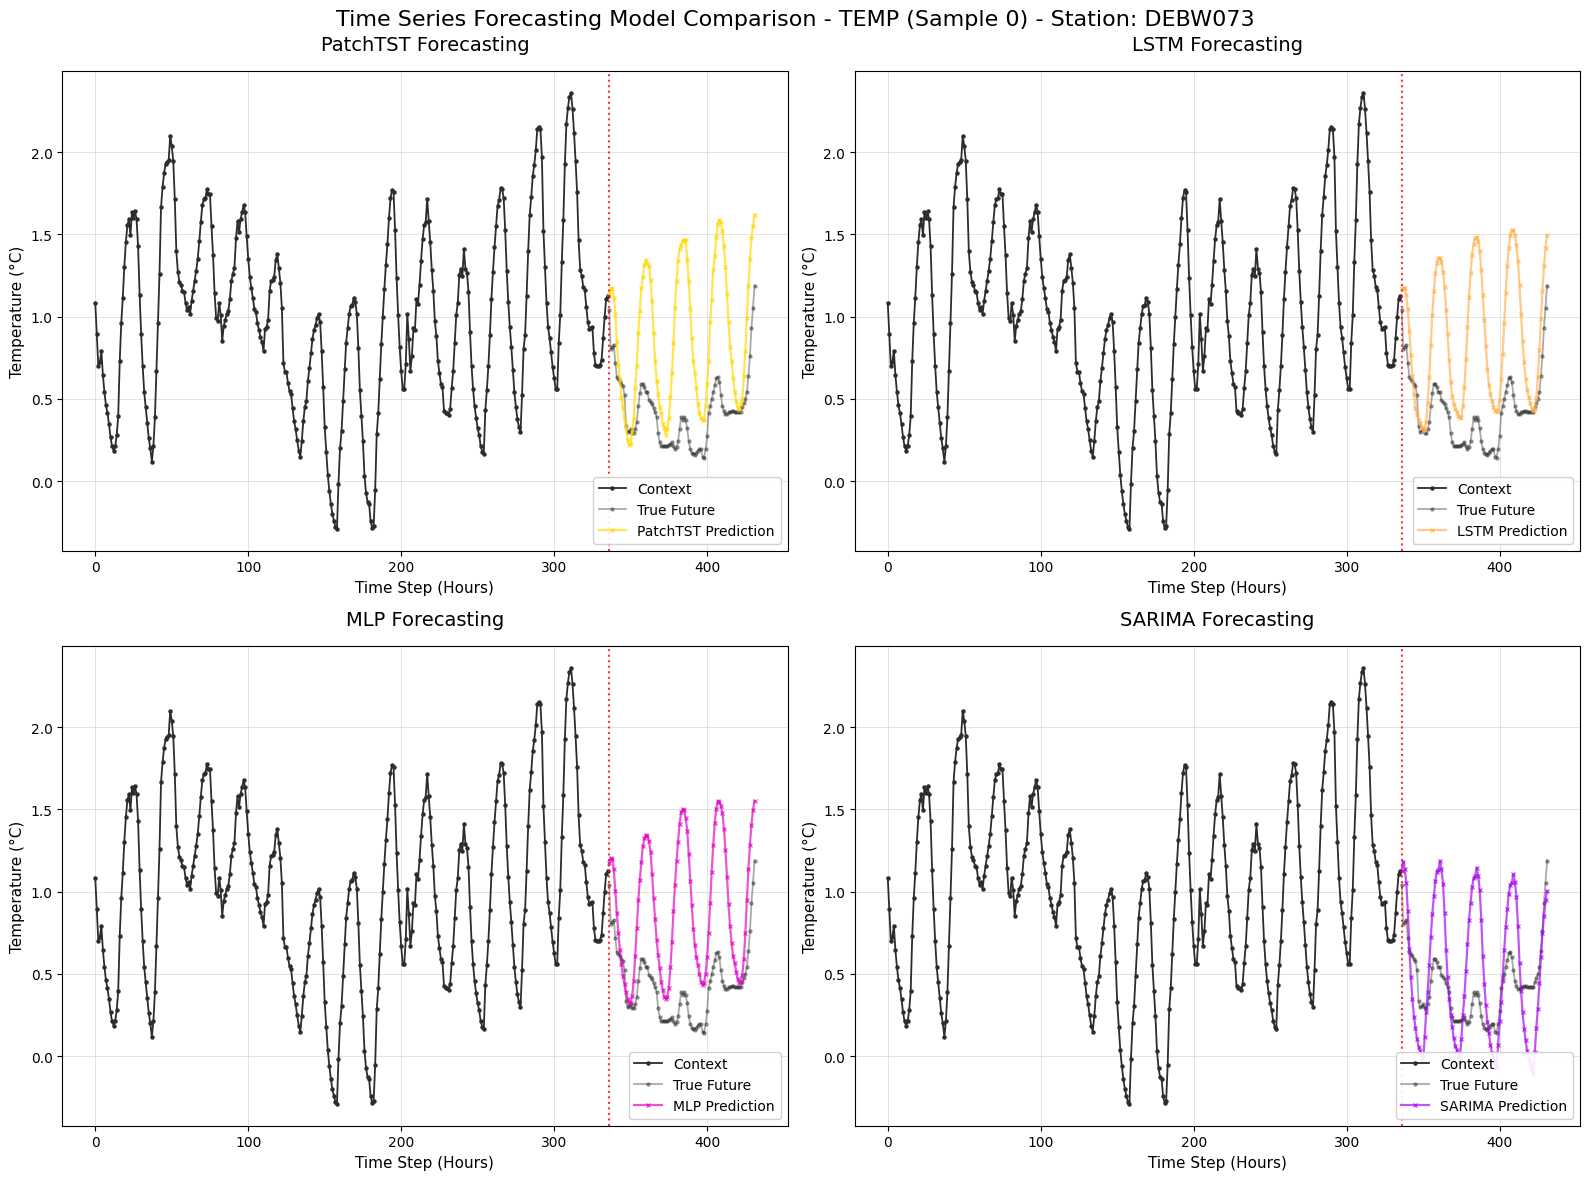

In [10]:
model_colors = {
    'patchtst': '#FFD700',
    'lstm': '#FFB14E',
    'mlp': '#DE00C3',
    'sarima': '#A400EC'
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Common styling
context_color = '#2C2C2C'
future_color = '#2C2C2C'
line_width = 1.3
marker_size = 2.2

for variable_idx in range(num_variables):
    sample_idx = 0  # Starting with first sample
    
    # Get common ground truth data (convert tensors to numpy)
    context = (test_dataset[sample_idx]['past_values'] * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']).detach().numpy()
    actual_future = (test_dataset[sample_idx]['future_values'] * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']).detach().numpy()
    
    # Get all model predictions
    predicted_future_patchtst = patchtst_predictions[sample_idx, :, variable_idx] * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']
    predicted_future_lstm = lstm_predictions[sample_idx, :, variable_idx] * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']
    
    # MLP prediction
    y_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == desired_station)[0]
    predicted_future_mlp = mlp_pred_sample * scaler_stats[observable_columns[variable_idx]]['std'] + scaler_stats[observable_columns[variable_idx]]['mean']
    
    # Model data
    models = [
        ('PatchTST', predicted_future_patchtst, model_colors['patchtst']),
        ('LSTM', predicted_future_lstm, model_colors['lstm']),
        ('MLP', predicted_future_mlp, model_colors['mlp']),
        ('SARIMA', predicted_future_sarimax, model_colors['sarima'])
    ]
    
    # Create 4 subplots - one for each model
    for i, (model_name, prediction, color) in enumerate(models):
        ax = axes[i]
        
        # Plot ground truth context and future
        ax.plot(range(context_window), context.flatten(), 
               label="Context", color=context_color, linewidth=line_width, 
               marker='o', markersize=marker_size, alpha=1.0)
        
        ax.plot(range(context_window, context_window + prediction_horizon), actual_future.flatten(), 
               label="True Future", color=future_color, linewidth=line_width,
               marker='o', markersize=marker_size, alpha=0.4)
        
        # Plot model prediction
        ax.plot(range(context_window, context_window + prediction_horizon), prediction.flatten(), 
               label=f"{model_name} Prediction", color=color, linewidth=line_width+0.3,
               linestyle='-', marker='x', markersize=marker_size+1, alpha=0.666)
        
        # Styling
        ax.set_title(f"{model_name} Forecasting", fontsize=14, pad=15)
        ax.set_xlabel("Time Step (Hours)", fontsize=11)
        ax.set_ylabel("Temperature (°C)", fontsize=11)
        ax.grid(True, alpha=0.5, linestyle='-', linewidth=0.5)
        ax.legend(loc='lower right', fontsize=10, framealpha=0.9)
        
        # Add vertical line to separate context from prediction
        ax.axvline(x=context_window, color='red', linestyle=':', alpha=0.8, linewidth=1.5)

plt.suptitle(f'Time Series Forecasting Model Comparison - {observable_columns[0].upper()} (Sample {sample_idx}) - Station: {desired_station}', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
{'PatchTST': 0.25451738, 'LSTM': 0.25502515, 'MLP': 0.27757758, 'SARIMA': 0.2539805320117907}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
{'PatchTST': 0.27485982, 'LSTM': 0.17813617, 'MLP': 0.27002594, 'SARIMA': 0.29597566930772795}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/home/philipp/Documents/mless/venv310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


{'PatchTST': 0.4611753, 'LSTM': 0.44681874, 'MLP': 0.4629728, 'SARIMA': 0.5457842071994764}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/home/philipp/Documents/mless/venv310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'PatchTST': 0.3671864, 'LSTM': 0.2727139, 'MLP': 0.2886689, 'SARIMA': 0.5017133039424009}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/home/philipp/Documents/mless/venv310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'PatchTST': 0.26347303, 'LSTM': 0.25160095, 'MLP': 0.29324493, 'SARIMA': 0.4386935906406604}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
{'PatchTST': 0.17559318, 'LSTM': 0.15653239, 'MLP': 0.1432559, 'SARIMA': 0.12149313771996566}


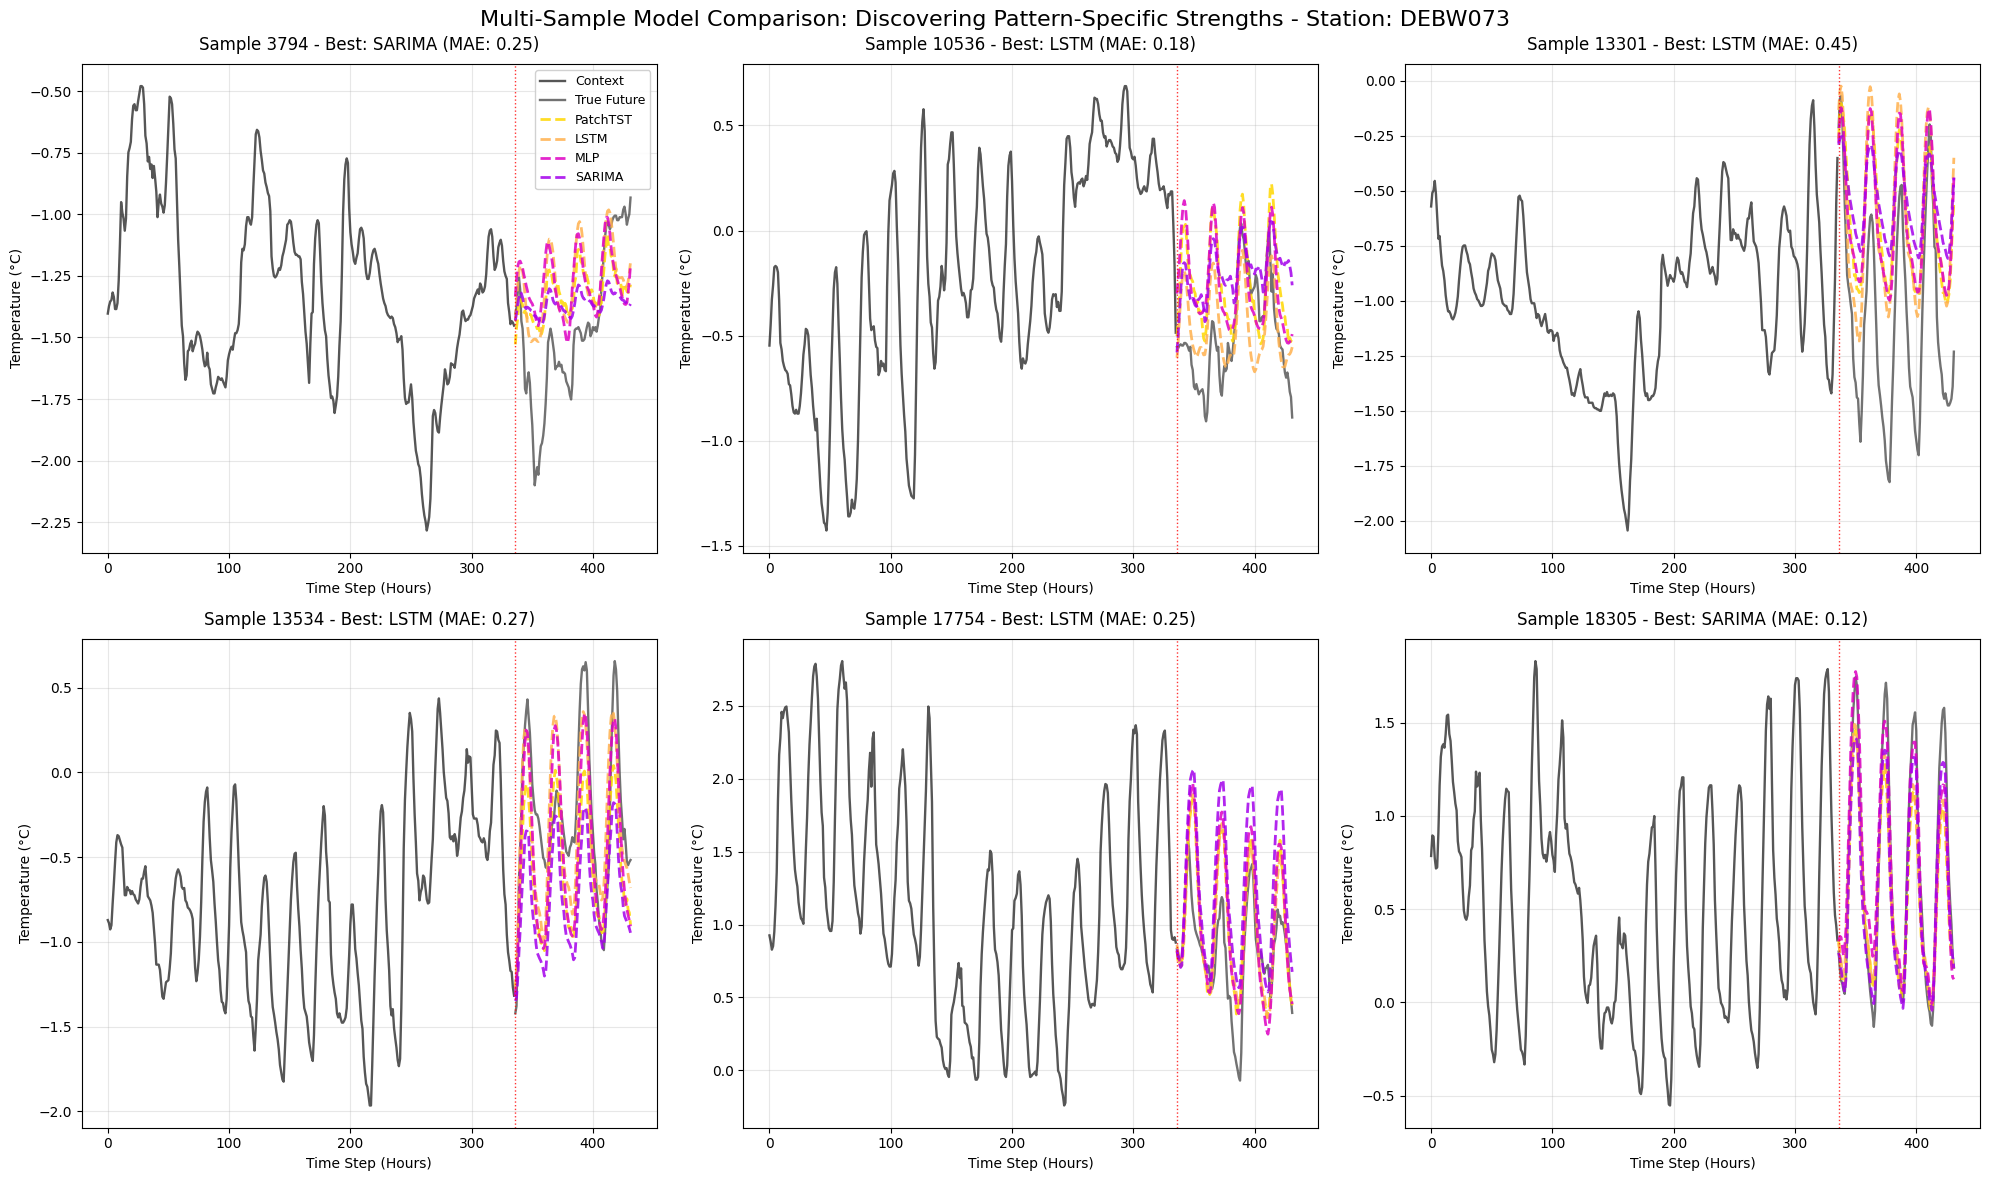

In [16]:
# 🔍 Multi-Sample Analysis: How Models Handle Different Patterns
# Explore model behavior across multiple random samples

# Select diverse samples for comparison
np.random.seed(42)  # For reproducible results
n_samples_to_compare = 6
total_samples = len(test_dataset)
sample_indices = np.random.choice(total_samples, n_samples_to_compare, replace=False)
sample_indices = np.sort(sample_indices)  # Sort for easier interpretation

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for plot_idx, sample_idx in enumerate(sample_indices):
    ax = axes[plot_idx]
    
    # Get ground truth for this sample (convert tensors to numpy)
    context = (test_dataset[sample_idx]['past_values'] * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']).detach().numpy()
    actual_future = (test_dataset[sample_idx]['future_values'] * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']).detach().numpy()
    
    # Get all predictions for this sample
    pred_patchtst = patchtst_predictions[sample_idx, :, 0] * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']
    
    # FIXED: LSTM prediction for this specific sample
    X_sample_idx = np.flatnonzero(X_test_full[:, 0, 0] == desired_station)[sample_idx]
    X_sample = X_test_full[X_sample_idx, :, 1].astype(np.float32)
    pred_lstm_raw = lstm_models['temp'].predict(X_sample.reshape(1, context_length, 1)).flatten()
    pred_lstm = pred_lstm_raw * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']
    
    # FIXED: Update MLP and SARIMA for each sample
    # Get the corresponding sample from pkl data
    X_sample_idx = np.flatnonzero(X_test_full[:, 0, 0] == desired_station)[sample_idx]
    X_sample = X_test_full[X_sample_idx, :, 1].astype(np.float32)
    
    # MLP prediction for this specific sample
    pred_mlp_raw = mlp_model.predict(X_sample.reshape(1, -1).astype(np.float32)).flatten()
    pred_mlp = pred_mlp_raw * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']
    
    # SARIMA prediction for this specific sample  
    sarima_model_sample = SARIMAX(X_sample, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24)).fit(disp=False)
    pred_sarima = sarima_model_sample.get_forecast(steps=forecast_horizon).predicted_mean
    
    # Plot context and true future
    ax.plot(range(context_window), context.flatten(), 
           color=context_color, linewidth=1.7, alpha=0.8, label='Context')
    ax.plot(range(context_window, context_window + prediction_horizon), actual_future.flatten(), 
           color=future_color, linewidth=1.7, alpha=0.666, label='True Future')
    
    # Plot all model predictions with transparency
    ax.plot(range(context_window, context_window + prediction_horizon), pred_patchtst.flatten(), 
           color=model_colors['patchtst'], linewidth=2, linestyle='--', alpha=0.85, label='PatchTST')
    ax.plot(range(context_window, context_window + prediction_horizon), pred_lstm.flatten(), 
           color=model_colors['lstm'], linewidth=2, linestyle='--', alpha=0.85, label='LSTM')
    ax.plot(range(context_window, context_window + prediction_horizon), pred_mlp.flatten(), 
           color=model_colors['mlp'], linewidth=2, linestyle='--', alpha=0.85, label='MLP')
    ax.plot(range(context_window, context_window + prediction_horizon), pred_sarima.flatten(), 
           color=model_colors['sarima'], linewidth=2, linestyle='--', alpha=0.85, label='SARIMA')
    
    # Calculate simple metrics for this sample
    mae_patchtst = np.mean(np.abs(pred_patchtst.flatten() - actual_future.flatten()))
    mae_lstm = np.mean(np.abs(pred_lstm.flatten() - actual_future.flatten()))
    mae_mlp = np.mean(np.abs(pred_mlp.flatten() - actual_future.flatten()))
    mae_sarima = np.mean(np.abs(pred_sarima.flatten() - actual_future.flatten()))
    
    # Identify best model for this sample
    maes = {'PatchTST': mae_patchtst, 'LSTM': mae_lstm, 'MLP': mae_mlp, 'SARIMA': mae_sarima}
    best_model = min(maes, key=maes.get)
    print(str(maes))
    
    # Styling
    ax.set_title(f'Sample {sample_idx} - Best: {best_model} (MAE: {maes[best_model]:.2f})', 
                fontsize=12, pad=10)
    ax.set_xlabel('Time Step (Hours)', fontsize=10)
    ax.set_ylabel('Temperature (°C)', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add forecast separator
    ax.axvline(x=context_window, color='red', linestyle=':', alpha=0.8, linewidth=1)
    
    # Only show legend on first subplot to avoid clutter
    if plot_idx == 0:
        ax.legend(loc='upper right', fontsize=9, framealpha=0.9)

plt.suptitle(f'Multi-Sample Model Comparison: Discovering Pattern-Specific Strengths - Station: {desired_station}', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()
